In [12]:
# TODO: your agent here!

import random
from collections import namedtuple, deque

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size: maximum size of buffer
            batch_size: size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, batch_size=64):
        """Randomly sample a batch of experiences from memory."""
        return random.sample(self.memory, k=self.batch_size)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    
    
from keras import layers, models, optimizers,regularizers
from keras import backend as K

class Actor:
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, action_low, action_high):
        """Initialize parameters and build model.

        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            action_low (array): Min value of each action dimension
            action_high (array): Max value of each action dimension
        """
        self.state_size = state_size
        self.action_size = action_size
        self.action_low = action_low
        self.action_high = action_high
        self.action_range = self.action_high - self.action_low

        # Initialize any other variables here

        self.build_model()

    def build_model(self):
        """Build an actor (policy) network that maps states -> actions."""
        # Define input layer (states)
        states = layers.Input(shape=(self.state_size,), name='states')

        # Add hidden layers
        self.dropout_rate = 0.2
        net = layers.Dense(units=32, activation=None)(states)
        net = layers.BatchNormalization()(net)
        net = layers.Activation('relu')(net)
        net = layers.Dropout(self.dropout_rate)(net)
        net = layers.Dense(units=64, activation='relu')(net)
        net = layers.BatchNormalization()(net)
        net = layers.Activation('relu')(net)
        net = layers.Dropout(self.dropout_rate)(net)
        net = layers.Dense(units=32, activation='relu')(net)
        # Try different layer sizes, activations, add batch normalization, regularizers, etc.

        # Add final output layer with sigmoid activation
        raw_actions = layers.Dense(units=self.action_size, activation='sigmoid',
            name='raw_actions')(net)

        # Scale [0, 1] output for each action dimension to proper range
        actions = layers.Lambda(lambda x: (x * self.action_range) + self.action_low,
            name='actions')(raw_actions)

        # Create Keras model
        self.model = models.Model(inputs=states, outputs=actions)

        # Define loss function using action value (Q value) gradients
        action_gradients = layers.Input(shape=(self.action_size,))
        loss = K.mean(-action_gradients * actions)

        # Incorporate any additional losses here (e.g. from regularizers)

        # Define optimizer and training function
        optimizer = optimizers.Adam()
        updates_op = optimizer.get_updates(params=self.model.trainable_weights, loss=loss)
        self.train_fn = K.function(
            inputs=[self.model.input, action_gradients, K.learning_phase()],
            outputs=[],
            updates=updates_op)
        
        
        
        
class Critic:
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size):
        """Initialize parameters and build model.

        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size

        # Initialize any other variables here

        self.build_model()

    def build_model(self):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        # Define input layers
        states = layers.Input(shape=(self.state_size,), name='states')
        actions = layers.Input(shape=(self.action_size,), name='actions')

        # Add hidden layer(s) for state pathway
        self.dropout_rate = 0.2 
        net_states = layers.Dense(units=32, activation=None)(states)
        net_states = layers.BatchNormalization()(net_states)
        net_states = layers.Activation('relu')(net_states)
        net_states = layers.Dropout(self.dropout_rate)(net_states)
        net_states = layers.Dense(units=64, activation=None)(net_states)
        net_states = layers.BatchNormalization()(net_states)
        net_states = layers.Activation('relu')(net_states)


        # Add hidden layer(s) for action pathway
        net_actions = layers.Dense(units=32, activation=None)(actions)
        net_actions = layers.BatchNormalization()(net_actions)
        net_actions = layers.Activation('relu')(net_actions)
        net_actions = layers.Dropout(self.dropout_rate)(net_actions)
        net_actions = layers.Dense(units=64, activation=None)(net_actions)
        net_actions = layers.BatchNormalization()(net_actions)
        net_actions = layers.Activation('relu')(net_actions)


        # Try different layer sizes, activations, add batch normalization, regularizers, etc.

        # Combine state and action pathways
        net = layers.Add()([net_states, net_actions])
        net = layers.Activation('relu')(net)

        # Add more layers to the combined network if needed

        # Add final output layer to prduce action values (Q values)
        Q_values = layers.Dense(units=1, name='q_values')(net)

        # Create Keras model
        self.model = models.Model(inputs=[states, actions], outputs=Q_values)

        # Define optimizer and compile model for training with built-in loss function
        optimizer = optimizers.Adam()
        self.model.compile(optimizer=optimizer, loss='mse')

        # Compute action gradients (derivative of Q values w.r.t. to actions)
        action_gradients = K.gradients(Q_values, actions)

        # Define an additional function to fetch action gradients (to be used by actor model)
        self.get_action_gradients = K.function(
            inputs=[*self.model.input, K.learning_phase()],
            outputs=action_gradients)
          
        
class DDPG():
    """Reinforcement Learning agent that learns using DDPG."""
    def __init__(self, task):
        self.task = task
        self.state_size = task.state_size
        self.action_size = task.action_size
        self.action_low = task.action_low
        self.action_high = task.action_high

        # Actor (Policy) Model
        self.actor_local = Actor(self.state_size, self.action_size, self.action_low, self.action_high)
        self.actor_target = Actor(self.state_size, self.action_size, self.action_low, self.action_high)

        # Critic (Value) Model
        self.critic_local = Critic(self.state_size, self.action_size)
        self.critic_target = Critic(self.state_size, self.action_size)

        # Initialize target model parameters with local model parameters
        self.critic_target.model.set_weights(self.critic_local.model.get_weights())
        self.actor_target.model.set_weights(self.actor_local.model.get_weights())

        # Noise process
        self.exploration_mu = 0
        self.exploration_theta = 0.15
        self.exploration_sigma = 0.2
        self.noise = OUNoise(self.action_size, self.exploration_mu, self.exploration_theta, self.exploration_sigma)

        # Replay memory
        self.buffer_size = 100000
        self.batch_size = 64
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size)

        # Algorithm parameters
        self.gamma = 0.99  # discount factor
        self.tau = 0.01  # for soft update of target parameters
        
        # Score tracker and learning parameters
        self.best_score = -np.inf
        self.noise_scale = 0.1

    def reset_episode(self):
        self.total_reward = 0.0
        self.count = 0
        self.noise.reset()
        state = self.task.reset()
        self.last_state = state
        return state

    def step(self, action, reward, next_state, done):
        
        # Save experience / reward
        self.total_reward += reward
        self.count += 1
        
        # update score
        self.score = self.total_reward / float(self.count) if self.count else 0.0
        if self.score > self.best_score:
            self.best_score = self.score
        
        
         # Save experience / reward
        self.memory.add(self.last_state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)

        # Roll over last state and action
        self.last_state = next_state

    def act(self, state):
        """Returns actions for given state(s) as per current policy."""
        state = np.reshape(state, [-1, self.state_size])
        action = self.actor_local.model.predict(state)[0]
        return list(action + self.noise.sample())  # add some noise for exploration

    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples."""
        # Convert experience tuples to separate arrays for each element (states, actions, rewards, etc.)
        states = np.vstack([e.state for e in experiences if e is not None])
        actions = np.array([e.action for e in experiences if e is not None]).astype(np.float32).reshape(-1, self.action_size)
        rewards = np.array([e.reward for e in experiences if e is not None]).astype(np.float32).reshape(-1, 1)
        dones = np.array([e.done for e in experiences if e is not None]).astype(np.uint8).reshape(-1, 1)
        next_states = np.vstack([e.next_state for e in experiences if e is not None])

        # Get predicted next-state actions and Q values from target models
        #     Q_targets_next = critic_target(next_state, actor_target(next_state))
        actions_next = self.actor_target.model.predict_on_batch(next_states)
        Q_targets_next = self.critic_target.model.predict_on_batch([next_states, actions_next])

        # Compute Q targets for current states and train critic model (local)
        Q_targets = rewards + self.gamma * Q_targets_next * (1 - dones)
        self.critic_local.model.train_on_batch(x=[states, actions], y=Q_targets)

        # Train actor model (local)
        action_gradients = np.reshape(self.critic_local.get_action_gradients([states, actions, 0]), (-1, self.action_size))
        self.actor_local.train_fn([states, action_gradients, 1])  # custom training function

        # Soft-update target models
        self.soft_update(self.critic_local.model, self.critic_target.model)
        self.soft_update(self.actor_local.model, self.actor_target.model)   

    def soft_update(self, local_model, target_model):
        """Soft update model parameters."""
        local_weights = np.array(local_model.get_weights())
        target_weights = np.array(target_model.get_weights())

        assert len(local_weights) == len(target_weights), "Local and target model parameters must have the same size"

        new_weights = self.tau * local_weights + (1 - self.tau) * target_weights
        target_model.set_weights(new_weights)
        
        
        
import numpy as np        
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu, theta, sigma):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = self.mu

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [13]:
%load_ext autoreload
%autoreload 2

import sys
import csv
import pandas as pd
import numpy as np
from task import Task
# from agents.agent import DDPG

num_episodes = 1000
target_pos = np.array([0., 0., 10.])
# init_pose = np.array([0., 0., 0., 0., 0., 0.])
task = Task(target_pos = target_pos)
agent = DDPG(task) 

labels = ['episode', 'total_reward','score','time', 
          'x', 'y', 'z', 'phi', 'theta', 'psi',
          'x_velocity','y_velocity', 'z_velocity',
          'phi_velocity', 'theta_velocity','psi_velocity',
          'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

file_output = 'data.txt'

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    for i_episode in range(1, num_episodes+1):
        state = agent.reset_episode() # start a new episode
        while True:
            rotor_speeds = agent.act(state) 
            next_state, reward, done = task.step(rotor_speeds)
            agent.step(rotor_speeds, reward, next_state, done)
            state = next_state
            if done:
                print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                    i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  
                
                to_write = [i_episode] + [agent.total_reward] + [agent.score] + [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
                for ii in range(len(labels)):
                    results[labels[ii]].append(to_write[ii])
                writer.writerow(to_write)
                break
        sys.stdout.flush()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode = 1000, score =   3.000 (best =   3.000), noise_scale = 0.1

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

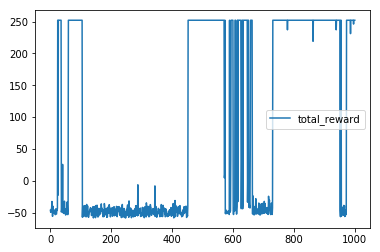

In [14]:
## TODO: Plot the rewards.

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(results['episode'], results['total_reward'], label='total_reward')
plt.legend()
_ = plt.ylim()


In [15]:
# use my trained agent to fly quadcopter
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi']
results = {x : [] for x in labels}

state = agent.reset_episode()


with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act(state)
        next_state, reward, done = task.step(rotor_speeds)
        agent.step(rotor_speeds, reward, next_state, done)
        state = next_state
        to_write =  [task.sim.time] + list(task.sim.pose) 
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break
            

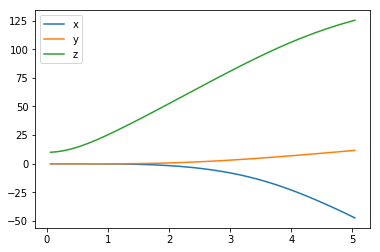

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**: I choose taking off as my task. My reward function is 
              
              reward = 1 - 0.5 * min (-xy_difference , 0)  
              #if the xy_difference has non-zero value, negative reward, it it is zero, then zero reward
              + 0.3 * (self.sim.pose[2] - self.target_pos[2]).sum()  
              #if pose bigger than 10, postitive reward, if smaller than 10, negative reward
               + 0.3 * self.sim.v[2] # if the v[2] bigger than zero, positive reward, else negative


**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:I used the actor and critic method and tuning the parameters in the model.
my discount factor, gamma = 0.99. I do not have an epsilon, since I used the function approximation, instead of setting a greedy epsilon policy. my learning rate alpha = 0.001 by default in the adam optimizer.

the neural network for my actor fuction is uding the following architecture:
        
        self.dropout_rate = 0.2
        net = layers.Dense(units=32, activation=None)(states)
        net = layers.BatchNormalization()(net)
        net = layers.Activation('relu')(net)
        net = layers.Dropout(self.dropout_rate)(net)
        net = layers.Dense(units=64, activation='relu')(net)
        net = layers.BatchNormalization()(net)
        net = layers.Activation('relu')(net)
        net = layers.Dropout(self.dropout_rate)(net)
        net = layers.Dense(units=32, activation='relu')(net)

the neural network for my critcs fuction is uding the following architecture:
        #Add hidden layer(s) for state pathway
        self.dropout_rate = 0.2 
        net_states = layers.Dense(units=32, activation=None)(states)
        net_states = layers.BatchNormalization()(net_states)
        net_states = layers.Activation('relu')(net_states)
        net_states = layers.Dropout(self.dropout_rate)(net_states)
        net_states = layers.Dense(units=64, activation=None)(net_states)
        net_states = layers.BatchNormalization()(net_states)
        net_states = layers.Activation('relu')(net_states)


        #Add hidden layer(s) for action pathway
        net_actions = layers.Dense(units=32, activation=None)(actions)
        net_actions = layers.BatchNormalization()(net_actions)
        net_actions = layers.Activation('relu')(net_actions)
        net_actions = layers.Dropout(self.dropout_rate)(net_actions)
        net_actions = layers.Dense(units=64, activation=None)(net_actions)
        net_actions = layers.BatchNormalization()(net_actions)
        net_actions = layers.Activation('relu')(net_actions)


**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:
It was not an easy task.
The learning curve is an aha moment at about 400 episode, but still not stable.
The final performance of the agent is 3.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:
the hardest part of the project is getting started, and then specifying the reward function.Tuning the model to make it fly is also challenging.

the interesting part is quadcopter still behaved poorly sometimes even after a temporarily stable on the getting the reward.